In [1]:
%load_ext autoreload
%autoreload 2

In [91]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from networkx.drawing.nx_agraph import graphviz_layout
import seaborn as sns
import numpy as np
import networkx as nx
import pandas as pd

from sklearn import preprocessing

In [4]:
import privtree
import khist

In [117]:
A = np.random.normal(loc=1, scale=0.1, size=50)
A = np.r_[A, np.random.normal(loc=5, scale=3, size=50)].reshape(-1, 1)
scaler = preprocessing.MinMaxScaler()
A = scaler.fit_transform(A)

In [118]:
eps = 1.0
myprivtree = privtree.PrivTree(A, eps, [(0.0, 1.0)], ['real'])
myprivtree.partition()
G = myprivtree.naive_est()

3.0 0 2.0794415416798357


In [128]:
leaves = sorted(privtree.get_leaves(G), key=lambda x: x.lb[0])
print(f'# leaves: {len(leaves)}')
khist_A = np.array([leaf.var.value for leaf in leaves])
khist_A = khist_A / khist_A.sum()
khist_B = np.array([leaf.ub[0] - leaf.lb[0] for leaf in leaves])

k = 5
X, dp = khist.solve_khist(khist_A, khist_B, k)

# leaves: 38


Text(0.5, 0, 'Data Support')

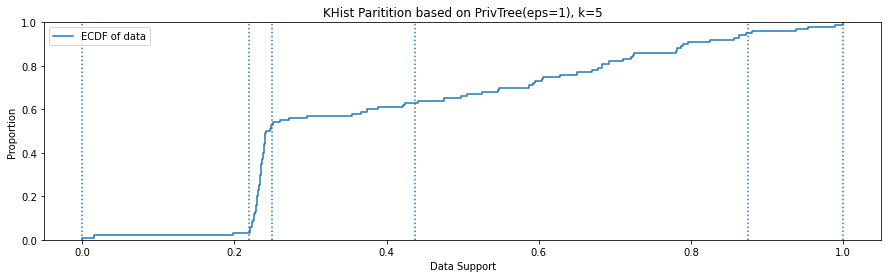

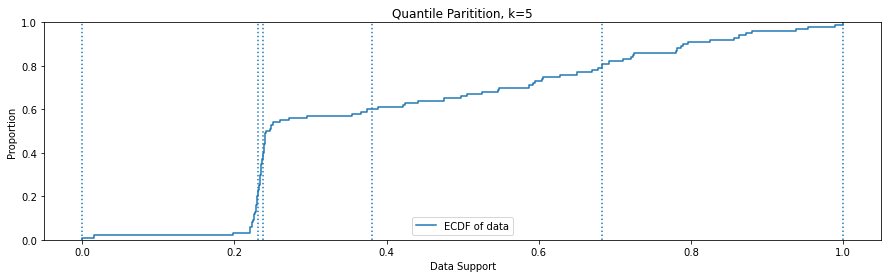

In [129]:
S = np.cumsum(X)
P = np.r_[0, np.cumsum(khist_B)[S-1]]

fig, ax = plt.subplots(figsize=(15, 4))
sns.ecdfplot(A, label='ECDF of data')

for p in P:
    ax.axvline(p, ls=':')
ax.legend()
    
ax.set_title(f'KHist Paritition based on PrivTree(eps=1), k={k}')
ax.set_xlabel('Data Support')

fig, ax = plt.subplots(figsize=(15, 4))
sns.ecdfplot(A, label='ECDF of data')

P = np.quantile(A, np.linspace(0,1,k+1))
for p in P:
    ax.axvline(p, ls=':')
ax.legend()
    
ax.set_title(f'Quantile Paritition, k={k}')
ax.set_xlabel('Data Support')

# 1D-Case, Integer Partition

Text(0.5, 1.0, 'ECDF of capital-gain in adult dataset \n x: symlog scale, integer domain')

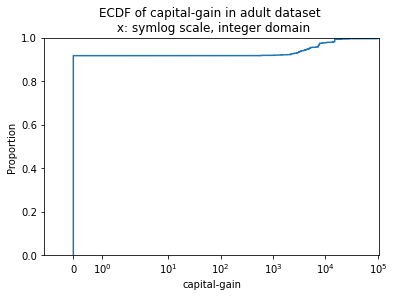

In [157]:
adult = pd.read_csv('./adult/adult.csv')
fig, ax = plt.subplots()
sns.ecdfplot(adult['capital-gain'])
ax.set_xscale('symlog')
ax.set_xlim(-1, None)
ax.set_title('ECDF of capital-gain in adult dataset \n x: symlog scale, integer domain')

In [160]:
eps = 1.0
A = adult['capital-gain'].values.reshape(-1, 1)
myprivtree = privtree.PrivTree(A, eps, [(0, int(np.max(A)))], ['int'])
G, root = myprivtree.partition()
G = myprivtree.naive_est()

3.0 0 2.0794415416798357


In [172]:
n = len(A)
est_n = root.var.value
df = pd.DataFrame({'lb':[leaf.lb[0] for leaf in leaves], 
                   'ub':[leaf.ub[0] for leaf in leaves], 
                   'real cnt':[leaf.c for leaf in leaves],
                   'est cnt':[int(leaf.var.value / est_n * n) for leaf in leaves]})
df.to_csv('temp.csv', index=False)

In [171]:
leaves = sorted(privtree.get_leaves(G), key=lambda x: x.lb[0])
print(f'# leaves: {len(leaves)}')
khist_A = np.array([leaf.var.value for leaf in leaves])
khist_A = khist_A / khist_A.sum()
khist_B = np.array([leaf.ub[0] - leaf.lb[0] for leaf in leaves])

k = 15
X, dp = khist.solve_khist(khist_A, khist_B, k)

# leaves: 374


In [173]:
S = np.r_[1, np.cumsum(X)]
n = len(A)
est_n = root.var.value
df = pd.DataFrame({'lb':[leaves[s-1].lb[0] for s in S[:-1]], 
                   'ub':[leaves[s-2].ub[0] for s in S[1:]], 
                   'real cnt': list(map(np.sum, np.split([leaf.c for leaf in leaves], np.cumsum(X))[:-1])),
                   'est cnt': list(map(np.sum, np.split(
                       [int(leaf.var.value / est_n * n) for leaf in leaves], np.cumsum(X))[:-1]))
                  })
df

,lb,ub,real cnt,est cnt
0,0,5,29849,24387
1,6,2148,173,835
2,2149,3327,492,1677
3,3328,4675,351,1085
4,4676,6640,270,683
5,6641,7691,571,986
6,7692,10523,128,662
7,10524,13867,47,189
8,13868,15027,419,796
9,15028,20069,45,332


In [137]:
leaves[4].lb

array([7])

Text(0.5, 0, 'Data Support')

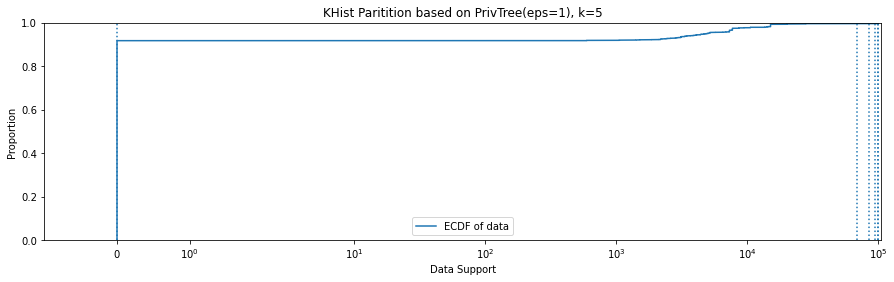

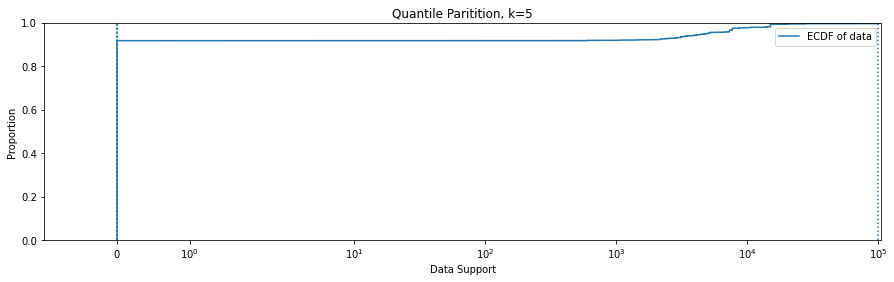

In [107]:
S = np.cumsum(X)
P = np.r_[0, np.cumsum(khist_B)[S-1]]

fig, ax = plt.subplots(figsize=(15, 4))
sns.ecdfplot(A, label='ECDF of data')

for p in P:
    ax.axvline(p, ls=':')
ax.set_xscale('symlog')
ax.set_xlim(-1, None)
ax.legend()
    
ax.set_title(f'KHist Paritition based on PrivTree(eps=1), k={k}')
ax.set_xlabel('Data Support')

fig, ax = plt.subplots(figsize=(15, 4))
sns.ecdfplot(A, label='ECDF of data')

P = np.quantile(A, np.linspace(0,1,k+1))
for p in P:
    ax.axvline(p, ls=':')
ax.set_xscale('symlog')
ax.set_xlim(-1, None)
ax.legend()
    
ax.set_title(f'Quantile Paritition, k={k}')
ax.set_xlabel('Data Support')

# 2D-Case, Heruistic Algorithm

In [87]:
A = np.random.uniform(0, 1, size=(100, 2))
A = np.random.normal(loc=0.5, scale=0.1, size=(100, 2))
A = np.clip(np.random.multivariate_normal(mean=(0.5, 0.5), cov=np.array(((0.1, 0.08), (0.08, 0.1)))/2, size=500), 0, 1)
#A = np.clip(np.random.multivariate_normal(mean=(0.5, 0.01), cov=np.array(((0.1, 0), (0, 0.001)))/2, size=1000), 0, 1)

In [89]:
eps = 1.0
privt = privtree.PrivTree(A, eps)
privt_G, _ = privt.partition()

2.3333333333333335 0 3.2346868426130784


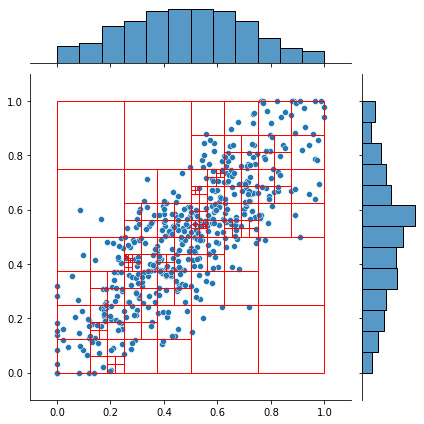

In [90]:
G = privt_G
leaves = [x for x in G.nodes() if G.out_degree(x)==0 and G.in_degree(x)==1]

g = sns.jointplot(x=A[:, 0], y=A[:, 1])
ax = g.ax_joint

for leaf in leaves:
    lb = leaf.lb
    ub = leaf.ub
    #print(leaf.c)
    #print(lb, ub)
    # assume 2d
    rect = patches.Rectangle((lb[0],lb[1]), ub[0]-lb[0], ub[1]-lb[1], edgecolor='r', facecolor="none")
    ax.add_patch(rect)
    #break
    
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
plt.show()